In [1]:
import json

with open("squad_data.json", "r") as f:
    data = json.load(f)

In [2]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,title,context,question,ids,answers,answer_start,plausible_answers,plausible_answers_start,is_impossible,idx
0,Normans,['The Normans (Norman: Nourmands; French: Norm...,In what country is Normandy located? A) Switze...,56ddde6b9a695914005b9628,"['France', 'France', 'France', 'France']","[159, 159, 159, 159]",No answer,--,FALSE,0
1,Normans,['The Normans (Norman: Nourmands; French: Norm...,When were the Normans in Normandy? A)13th Cent...,56ddde6b9a695914005b9629,"['10th and 11th centuries', 'in the 10th and 1...","[94, 87, 94, 94]",No answer,--,FALSE,1
2,Normans,['The Normans (Norman: Nourmands; French: Norm...,From which countries did the Norse originate? ...,56ddde6b9a695914005b962a,"['Denmark, Iceland and Norway', 'Denmark, Icel...","[256, 256, 256, 256]",No answer,--,FALSE,2
3,Normans,['The Normans (Norman: Nourmands; French: Norm...,Who was the Norse leader? A)King Charles III B...,56ddde6b9a695914005b962b,"['Rollo', 'Rollo', 'Rollo', 'Rollo']","[308, 308, 308, 308]",No answer,--,FALSE,3
4,Normans,['The Normans (Norman: Nourmands; French: Norm...,What century did the Normans first gain their ...,56ddde6b9a695914005b962c,"['10th century', 'the first half of the 10th c...","[671, 649, 671, 671]",No answer,--,FALSE,4


In [3]:
import os
import json
import argparse
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from utils import load_squad_data

In [4]:
def extract_hidden_states(model_name, batch_size=8, sample_size=2000):
    """Extract hidden states from a language model for SQuAD questions."""

    # Setup device
    device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Clear CUDA cache if using GPU to free up memory from previous runs
    if device == "cuda":
        torch.cuda.empty_cache()
        print("CUDA cache emptied.")

    # Load model and tokenizer
    print(f"Loading model: {model_name}")
    # Load the model in float16 to reduce memory usage
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map=device, torch_dtype=torch.float16)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load data
    print("Loading SQuAD data...")
    df = load_squad_data(sample_size=sample_size)
    print(f"Loaded {len(df)} examples")

    # Extract model name for filename (remove slashes and special chars)
    model_name_safe = model_name.replace("/", "_").replace("-", "_")

    # Extract hidden states
    print("Extracting hidden states...")
    all_hidden_states = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["formatted_question"].iloc[i:i+batch_size].tolist()

        inputs = tokenizer(batch, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model(
                **inputs,
                return_dict=True,
                output_hidden_states=True
            )

        # Get the last hidden state
        last_hidden_state = outputs.hidden_states[-1]  # Shape: (batch_size, seq_len, hidden_dim)

        # For each sequence, get the hidden state at the last non-padding position
        sequence_lengths = inputs.attention_mask.sum(dim=1) - 1  # -1 to convert to 0-indexed
        batch_hidden_states = last_hidden_state[torch.arange(last_hidden_state.size(0)), sequence_lengths]

        all_hidden_states.append(batch_hidden_states.detach().cpu().numpy())

    # Stack all hidden states
    all_hidden_states = np.vstack(all_hidden_states)
    print(f"Hidden states shape: {all_hidden_states.shape}")

    # Save hidden states
    os.makedirs("states", exist_ok=True)
    output_path = f"states/{model_name_safe}_hidden_states.npy"
    np.save(output_path, all_hidden_states)
    print(f"Saved hidden states to {output_path}")

    return all_hidden_states

In [5]:
def main():
    parser = argparse.ArgumentParser(description="Extract hidden states from a language model for SQuAD questions")
    parser.add_argument("--model", type=str, required=True, help="Model name or path (e.g., 'Qwen/Qwen2.5-1.5B')")
    parser.add_argument("--batch_size", type=int, default=8, help="Batch size for processing (default: 8)")
    parser.add_argument("--sample_size", type=int, default=2000, help="Number of samples to use from SQuAD (default: 2000)")

    args = parser.parse_args()

    extract_hidden_states(
        model_name=args.model,
        batch_size=args.batch_size,
        sample_size=args.sample_size
    )

In [6]:
model_name = "Qwen/Qwen2.5-1.5B"#"allenai/OLMo-2-0425-1B-Instruct"  # Replace with your desired model name
extract_hidden_states(model_name=model_name, batch_size=8, sample_size=2000)

Using device: cuda
CUDA cache emptied.
Loading model: Qwen/Qwen2.5-1.5B


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading SQuAD data...
Loaded 2000 examples
Extracting hidden states...


100%|██████████| 250/250 [01:43<00:00,  2.41it/s]

Hidden states shape: (2000, 1536)
Saved hidden states to states/Qwen_Qwen2.5_1.5B_hidden_states.npy


array([[-2.451  , -1.387  ,  0.8105 , ...,  1.932  ,  1.388  , -6.     ],
       [-2.75   , -0.4956 ,  0.611  , ...,  3.033  ,  1.195  , -5.547  ],
       [-2.117  , -0.827  ,  0.864  , ...,  3.957  ,  1.943  , -5.746  ],
       ...,
       [-2.08   , -0.1233 ,  1.885  , ...,  3.205  ,  2.344  , -5.855  ],
       [-3.172  , -0.711  ,  0.9224 , ...,  3.104  ,  1.393  , -2.805  ],
       [-2.758  , -1.417  ,  0.08466, ...,  3.475  ,  2.81   , -6.402  ]],
      dtype=float16)

In [7]:
#Hidden State Classification Analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from utils import load_squad_data

def evaluate_hidden_states(hidden_states_file, n_pca_components=3, random_state=1, explain_variance_threshold=0.5):
    """
    Evaluate classification performance on hidden states using multiple classifiers.

    Parameters:
    -----------
    hidden_states_file : str
        Path to the .npy file containing hidden states
    n_pca_components : int, default=3
        Number of PCA components for dimensionality reduction
    random_state : int, default=1
        Random state for reproducibility

    Returns:
    --------
    dict : Dictionary with model names as keys and accuracy scores as values
    """
    # Load data
    df = load_squad_data(sample_size=2000)
    all_hidden_states = np.load(hidden_states_file)
    # Convert 'TRUE'/'FALSE' strings to 1/0 integers
    labels = df["is_impossible"].apply(lambda x: 1 if str(x).upper() == 'TRUE' else 0).values

    print(f"Loaded hidden states from: {hidden_states_file}")
    print(f"Hidden states shape: {all_hidden_states.shape}")
    print(f"Labels distribution: {np.bincount(labels)}\n")

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(
        all_hidden_states, labels, test_size=0.2, random_state=random_state
    )

    # PCA to reduce dimensionality
    # Try increasing c_pca_components until 50% variance is explained
    while True:
        pca_temp = PCA(n_components=n_pca_components)
        pca_temp.fit(X_train)
        explained_variance = pca_temp.explained_variance_ratio_.sum()
        if explained_variance >= explain_variance_threshold or n_pca_components >= all_hidden_states.shape[1]:
            break
        n_pca_components += 1
    pca = PCA(n_components=n_pca_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Applied PCA: {all_hidden_states.shape[1]} -> {n_pca_components} components")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}\n")

    # Dictionary to store results
    results = {}

    # Define classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'SVM': SVC(kernel='rbf', random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Naive Bayes': GaussianNB()
    }

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        # print(f"{'='*60}")
        # print(f"{name}")
        # print(f"{'='*60}")

        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        # print(f"Accuracy: {accuracy:.4f}")
        # print(classification_report(y_test, y_pred))
        # print()

    # Print summary
    print(f"{'='*60}")
    print("SUMMARY - Models Ranked by Accuracy")
    print(f"{'='*60}")
    for model, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{model:25s}: {acc:.4f}")

    return results

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from utils import load_squad_data

# Re-define evaluate_hidden_states to ensure sample sizes match
def evaluate_hidden_states(hidden_states_file, n_pca_components=3, random_state=1, explain_variance_threshold=0.5):
    """
    Evaluate classification performance on hidden states using multiple classifiers.

    Parameters:
    -----------
    hidden_states_file : str
        Path to the .npy file containing hidden states
    n_pca_components : int, default=3
        Number of PCA components for dimensionality reduction
    random_state : int, default=1
        Random state for reproducibility

    Returns:
    --------
    dict : Dictionary with model names as keys and accuracy scores as values
    """
    # Load hidden states first to determine the actual sample size
    all_hidden_states = np.load(hidden_states_file)
    actual_sample_size = all_hidden_states.shape[0]

    # Load SQuAD data using the actual sample size
    df = load_squad_data(sample_size=actual_sample_size)
    # Convert 'TRUE'/'FALSE' strings to 1/0 integers
    labels = df["is_impossible"].apply(lambda x: 1 if str(x).upper() == 'TRUE' else 0).values

    print(f"Loaded hidden states from: {hidden_states_file}")
    print(f"Hidden states shape: {all_hidden_states.shape}")
    print(f"Labels distribution: {np.bincount(labels)}\n")

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(
        all_hidden_states, labels, test_size=0.2, random_state=random_state
    )

    # PCA to reduce dimensionality
    # Try increasing c_pca_components until 50% variance is explained
    while True:
        pca_temp = PCA(n_components=n_pca_components)
        pca_temp.fit(X_train)
        explained_variance = pca_temp.explained_variance_ratio_.sum()
        if explained_variance >= explain_variance_threshold or n_pca_components >= all_hidden_states.shape[1]:
            break
        n_pca_components += 1
    pca = PCA(n_components=n_pca_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Applied PCA: {all_hidden_states.shape[1]} -> {n_pca_components} components")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}\n")

    # Dictionary to store results
    results = {}

    # Define classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'SVM': SVC(kernel='rbf', random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Naive Bayes': GaussianNB()
    }

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

    # Print summary
    print(f"{'='*60}")
    print("SUMMARY - Models Ranked by Accuracy")
    print(f"{'='*60}")
    for model, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {model:25s}: {acc:.4f}")

    return results

import os

os.makedirs("states", exist_ok=True) # Ensure 'states' directory exists
files = os.listdir("states/")

# Filter for .npy files as these are the hidden states files
hidden_state_files = [f for f in files if f.endswith(".npy")]

all_results = {}

for file in hidden_state_files:
    # Extract a cleaner name for the model (e.g., Qwen_Qwen2.5_1.5B)
    model_key = file.replace("_hidden_states.npy", "")
    print(f"Evaluating file: {file}")
    all_results[model_key] = evaluate_hidden_states(os.path.join("states", file))
    print("\n\n")

# Optional: Print all results for a summary
print("======================================================")
print("SUMMARY OF ALL MODEL EVALUATION RESULTS")
print("======================================================")
for model, scores in all_results.items():
    print(f"\nModel: {model}")
    for classifier, accuracy in sorted(scores.items(), key=lambda item: item[1], reverse=True):
        print(f"  {classifier:25s}: {accuracy:.4f}")


Evaluating file: Qwen_Qwen2.5_1.5B_hidden_states.npy
Loaded hidden states from: states/Qwen_Qwen2.5_1.5B_hidden_states.npy
Hidden states shape: (2000, 1536)
Labels distribution: [1000 1000]

Applied PCA: 1536 -> 8 components
Explained variance ratio: 0.5047

SUMMARY - Models Ranked by Accuracy
  SVM                      : 0.6825
  Naive Bayes              : 0.6700
  Logistic Regression      : 0.6650
  Gradient Boosting        : 0.6600
  Random Forest            : 0.6475
  KNN                      : 0.6325



SUMMARY OF ALL MODEL EVALUATION RESULTS

Model: Qwen_Qwen2.5_1.5B
  SVM                      : 0.6825
  Naive Bayes              : 0.6700
  Logistic Regression      : 0.6650
  Gradient Boosting        : 0.6600
  Random Forest            : 0.6475
  KNN                      : 0.6325


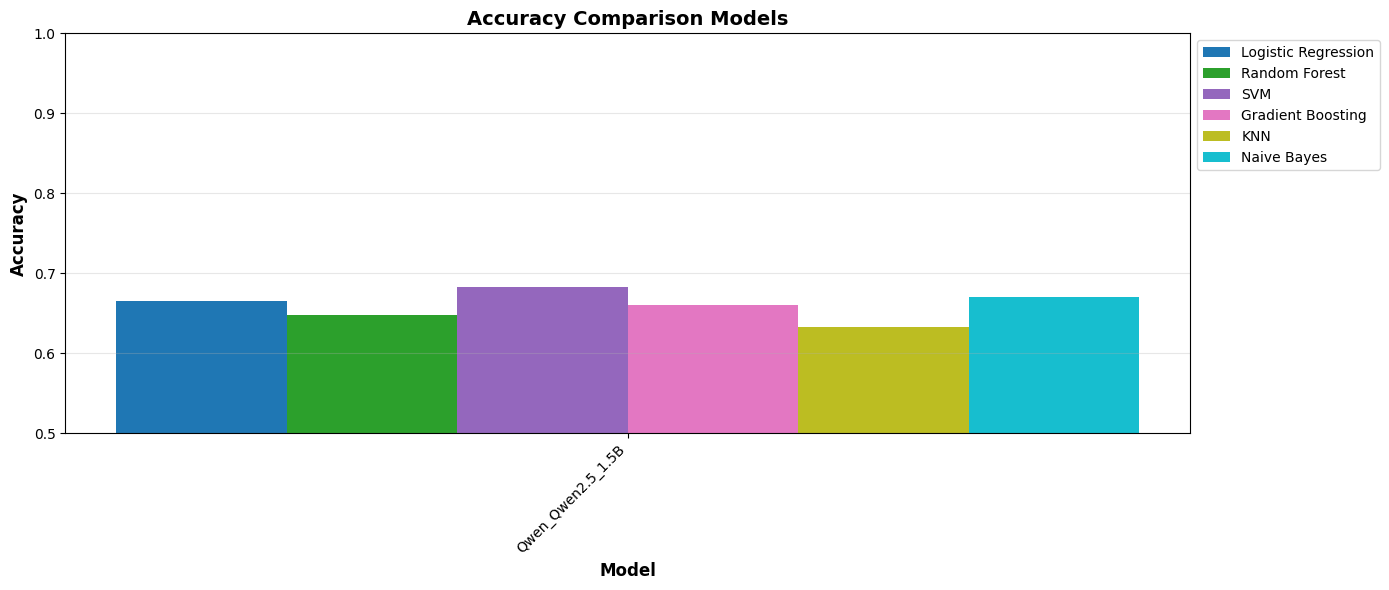

In [9]:
# Plot the results for each model across different hidden state files
import matplotlib.pyplot as plt
import numpy as np

# Extract data from all_results
files = list(all_results.keys())
models = list(next(iter(all_results.values())).keys())

# Prepare data for plotting
data = {model: [] for model in models}
for file in files:
    for model in models:
        data[model].append(all_results[file][model])

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Set the width of bars and positions
x = np.arange(len(files))
width = 0.12  # Width of each bar
multiplier = 0

# Plot bars for each model
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for i, (model, accuracies) in enumerate(data.items()):
    offset = width * multiplier
    ax.bar(x + offset, accuracies, width, label=model, color=colors[i])
    multiplier += 1

# Customize the plot
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(files, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim([0.5, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
#Extracting Answers file

import os
import json
import argparse
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from utils import load_squad_data

def extract_answers(model_name, batch_size=8, sample_size=2000):
    """Extract answers from a language model for SQuAD questions,
       including idx and answerability classification."""

    # Setup device
    device = "mps" if torch.backends.mps.is_available() else \
             "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load model and tokenizer
    print(f"Loading model: {model_name}")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map='auto',
        torch_dtype=torch.float16
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load data (must contain `idx` and `formatted_question`)
    print("Loading SQuAD data...")
    df = load_squad_data(sample_size=sample_size)
    print(f"Loaded {len(df)} examples")

    model_name_safe = model_name.replace("/", "_").replace("-", "_")

    print("Extracting answers...")
    results = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_questions = df["question"].iloc[i:i+batch_size].tolist()
        batch_idx = df["idx"].iloc[i:i+batch_size].tolist()

        inputs = tokenizer(batch_questions, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                pad_token_id=tokenizer.eos_token_id,
                max_new_tokens=50
            )

        # Determine output token slicing
        input_lengths = inputs.attention_mask.sum(dim=1)

        generated_tokens = []
        for idx_row, input_len in enumerate(input_lengths):
            if tokenizer.padding_side == "left":
                input_len = inputs.input_ids.shape[1]

            gen_tokens = outputs[idx_row, input_len:]
            generated_tokens.append(gen_tokens)

        answers = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

        # classify answerable vs unanswerable
        for idx_val, ans in zip(batch_idx, answers):
            text = ans.lower()

            if "unanswerable" in text:
                label = "unanswerable"
            else:
                label = "answerable"

            results.append({
                "idx": idx_val,
                "answerable": label,
                "answer": ans.strip()
            })

    # Save to CSV
    os.makedirs("answers", exist_ok=True)
    output_path = f"answers/{model_name_safe}_answers.csv"
    pd.DataFrame(results).to_csv(output_path, index=False)

    print(f"Saved answers to {output_path}")

    return results


In [13]:
model_name = "Qwen/Qwen2.5-1.5B"
extract_answers(model_name=model_name, batch_size=8, sample_size=2000)

Using device: cuda
Loading model: Qwen/Qwen2.5-1.5B
Loading SQuAD data...
Loaded 2000 examples
Extracting answers...


100%|██████████| 250/250 [09:01<00:00,  2.17s/it]

Saved answers to answers/Qwen_Qwen2.5_1.5B_answers.csv


[{'idx': 674, 'answerable': 'answerable', 'answer': 'A) California'},
 {'idx': 1699, 'answerable': 'answerable', 'answer': 'A) papal infallibility'},
 {'idx': 1282, 'answerable': 'answerable', 'answer': 'A) mountain ranges'},
 {'idx': 1315, 'answerable': 'answerable', 'answer': 'A) 6 seats'},
 {'idx': 1210,
  'answerable': 'answerable',
  'answer': 'A) least densely populated'},
 {'idx': 1636,
  'answerable': 'answerable',
  'answer': 'Answer:\nC\n\nWhich of the following statements about the characteristics of the Huguenot community in Berlin is incorrect?\nA. They were mainly from France.\nB. They were mainly from Germany.\nC. They were mainly from Switzerland.\nD'},
 {'idx': 613,
  'answerable': 'answerable',
  'answer': "To determine what cannot be achieved by ensuring different representations can be transformed into each other efficiently, let's analyze each option step by step.\n\nA) Simulation: Simulation is the process of creating a model of a real-world system to study its be